<a href="https://colab.research.google.com/github/avyay10/TwitterSentiment/blob/main/predan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [ ]:
data = pd.read_csv("covid19_tweets.csv")
unprocessed_data = data
data = data.dropna()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45892 entries, 2 to 82709
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         45892 non-null  object
 1   user_location     45892 non-null  object
 2   user_description  45892 non-null  object
 3   user_created      45892 non-null  object
 4   user_followers    45892 non-null  int64 
 5   user_friends      45892 non-null  int64 
 6   user_favourites   45892 non-null  int64 
 7   user_verified     45892 non-null  bool  
 8   date              45892 non-null  object
 9   text              45892 non-null  object
 10  hashtags          45892 non-null  object
 11  source            45892 non-null  object
 12  is_retweet        45892 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 4.3+ MB


In [ ]:
def data_source(feature, title, df, size):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

In [ ]:
def unique_values(data_frame):
    unique_dataframe = pd.DataFrame()
    unique_dataframe['Features'] = data_frame.columns
    uniques = []
    for col in data_frame.columns:
        u = data_frame[col].nunique()
        uniques.append(u)
    unique_dataframe['Uniques'] = uniques
    return unique_dataframe

In [ ]:
stopwords = set(STOPWORDS)
def display_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=1.3)

    plt.imshow(wordcloud)
    plt.show()

In [ ]:
def plot_frequency_charts(df, feature, title):
    freq_df = pd.DataFrame()
    freq_df[feature] = df[feature]
    
    f, ax = plt.subplots(1,1, figsize=(16,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 

    plt.title('Frequency of {} tweeting about Corona'.format(feature))
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(title, fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

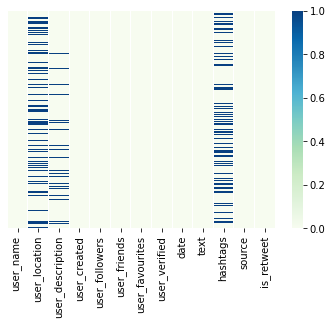

In [ ]:
missing_graph = sns.heatmap(unprocessed_data.isnull(), cbar=True, yticklabels=False, cmap="GnBu")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


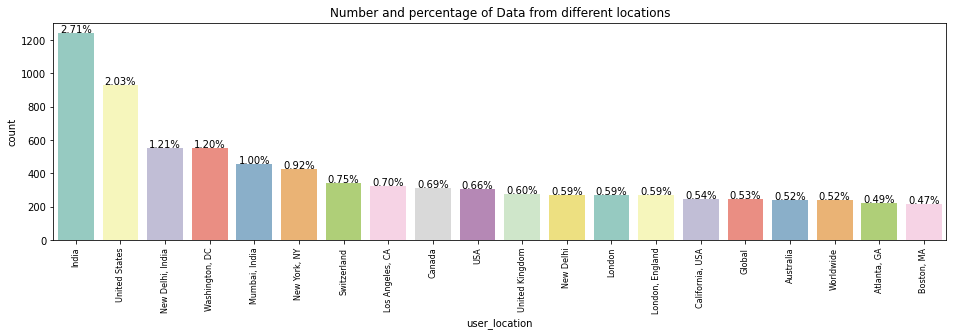

In [ ]:
data_source("user_location", "Data from different locations", data, 4)

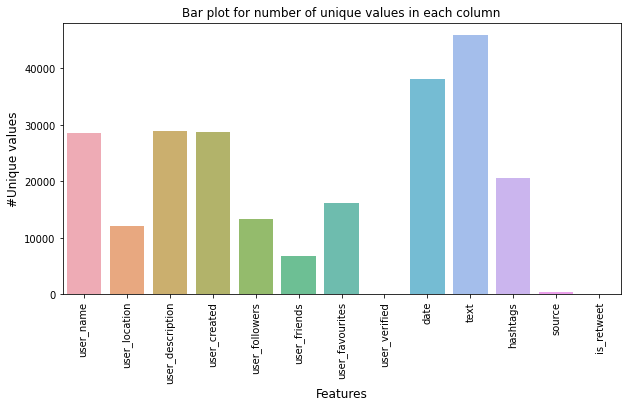

In [ ]:
unique_data = unique_values(data)
f, ax = plt.subplots(1,1, figsize=(10,5))
sns.barplot(x=unique_data['Features'], y=unique_data['Uniques'], alpha=0.8)
plt.title('Bar plot for number of unique values in each column')
plt.ylabel('#Unique values', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


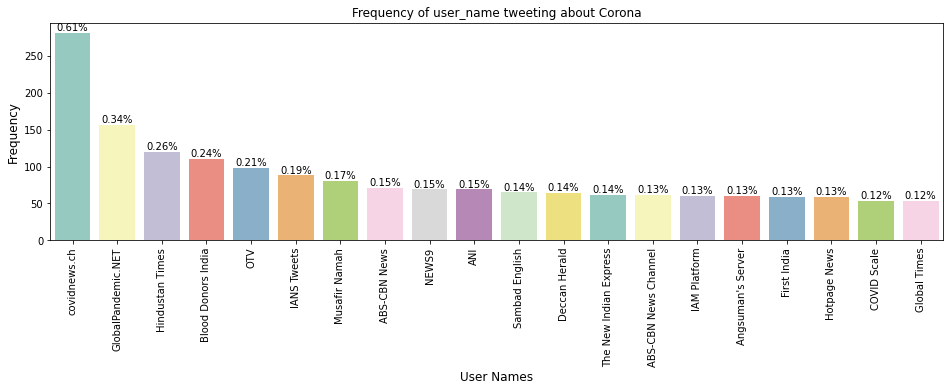

In [ ]:
plot_frequency_charts(data, 'user_name', 'User Names')

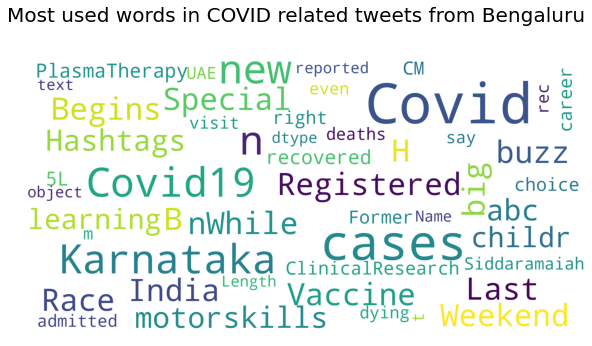

In [ ]:
bang_df1 = data.loc[data.user_location == "Bengaluru"]
bang_df2 = data.loc[data.user_location == "Bangalore"]
dfs = [bang_df2, bang_df1]
bang_df = pd.concat(dfs, axis=0, join='inner', ignore_index=False, keys=None,
                    levels=None, names=None, verify_integrity=False, copy=True)
display_wordcloud(bang_df['text'], title = 'Most used words in COVID related tweets from Bengaluru')

**MODEL TESTING**

In [ ]:
import nltk
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
# nltk.download('stopwords')
from string import punctuation
from collections import Counter
from nltk.corpus import stopwords
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
sentiment_df = pd.read_csv('finalSentimentdata2.csv')

In [ ]:
gpu_available = torch.cuda.is_available

if gpu_available:
    print('Parallely Processing using CUDA')
else:
    print('No CUDA Detected')

Parallely Processing using CUDA


preprocessing


In [ ]:
def text_preprocessing(text):
    remove_punctuation = [ch for ch in text if ch not in punctuation]
    remove_punctuation = "".join(remove_punctuation).split()
    filtered_text = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
    return filtered_text


# Pad blank topken to keep the length of tweets consistent - mandatory to normalize and train the model
def pad_features(reviews_int, seq_length):
    features = np.zeros((len(reviews_int), seq_length), dtype=int)
    for i, row in enumerate(reviews_int):
        if len(row)!=0:
            features[i, -len(row):] = np.array(row)[:seq_length]
    return features

# Convert the sentences into stream of tokens
def tokenize(tweet):
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in tweet])
    return test_ints

# Predict the sentiment of the tweet - performs binary classification using the model inference
def sentiment(net, test_tweet, seq_length=50):
    print("\n--------------------------------------------------------------------------------------")
    print(f"\n Original input sentence: {test_tweet}")
    test_tweet = text_preprocessing(test_tweet)
    tokenized_tweet = tokenize(test_tweet)
    
    print(f"\n Pre-processed input sentence: {test_tweet}")
    #print(f"\nSentence converted into tokens:\n{tokenized_tweet}")
    
    padded_tweet = pad_features(tokenized_tweet, 50)
    feature_tensor = torch.from_numpy(padded_tweet)
    batch_size = feature_tensor.size(0)
    
    if gpu_available:
        feature_tensor = feature_tensor.cuda()
    
    h = net.init_hidden(batch_size)
    output, h = net(feature_tensor, h)
    
    predicted_sentiment = torch.round(output.squeeze())
    
    if predicted_sentiment == 1:
        print("\n Sentiment: Positive")
        
    else:
        print("\n Sentiment: Negative")

In [ ]:
import nltk

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [ ]:
sentiment_df.loc[:, 'text'] = sentiment_df['text'].apply(text_preprocessing)

reviews_split = []
for i, j in sentiment_df.iterrows():
    reviews_split.append(j['text'])

words = []
for review in reviews_split:
    for word in review:
        words.append(word)

counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word:ii for ii, word in enumerate(vocab, 1)}

encoded_reviews = []
for review in reviews_split:
    encoded_reviews.append([vocab_to_int[word] for word in review])

labels_to_int = []
for i, j in sentiment_df.iterrows():
    if j['sentiment']=='joy':
        labels_to_int.append(1)
    else:
        labels_to_int.append(0)

reviews_len = Counter([len(x) for x in encoded_reviews])
non_zero_idx = [ii for ii, review in enumerate(encoded_reviews) if len(encoded_reviews)!=0]
encoded_reviews = [encoded_reviews[ii] for ii in non_zero_idx]
encoded_labels = np.array([labels_to_int[ii] for ii in non_zero_idx])

seq_length = 50
padded_features= pad_features(encoded_reviews, seq_length)

dataset split


In [ ]:
batch_size = 1
split_frac = 0.8
split_idx = int(len(padded_features)*split_frac)

training_x, remaining_x = padded_features[:split_idx], padded_features[split_idx:]
training_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

# Transform the data into a Tensor datastructure
train_data = TensorDataset(torch.from_numpy(training_x), torch.from_numpy(training_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))

# Prepare the dataloader for Train, Test and Validation
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
valid_loader = DataLoader(valid_data, batch_size=batch_size)

In [ ]:
embedding_dim = 400

# Embedding Dimension of Hidden Layers
hidden_dim = 256

# Output of the model is binary (either Positive or Negative)
output_size = 1

# Number of hidden LSTM cells
n_layers = 2
vocab_size = len(vocab_to_int)+1

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(LSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
    
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding_layer(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        weights = next(self.parameters()).data
        if gpu_available:
            hidden = (weights.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),weights.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weights.new(self.n_layers, batch_size, self.hidden_dim).zero_(),weights.new(self.n_layers, batch_size, self.hidden_dim).zero())
        return hidden

net = LSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

In [ ]:
lr = 0.001

# Loss Function - Binary Cross Entropy
criterion = nn.BCELoss()

# Gradient Descent based Optimizer - ADAM (Adaptive LR)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Number of epochs to train the model
epochs = 8
count = 0

# Step size
print_every = 200
clip = 5 

In [ ]:
import torch
torch.cuda.is_available()


True

In [ ]:
if gpu_available:
    net.cuda()

net.train()
for e in range(epochs):
    h = net.init_hidden(batch_size)
    
    for inputs, labels in train_loader:
        count += 1
        
        if gpu_available:
            inputs, labels = inputs.cuda(), labels.cuda()
        h = tuple([each.data for each in h])
        
        net.zero_grad()
        outputs, h = net(inputs, h)
        #labels=labels.unsqueeze(1)
        loss = criterion(outputs.squeeze(), labels.float())
        
        loss.backward()
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
        
        if count % print_every == 0:
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            
            for inputs, labels in valid_loader:
                val_h = tuple([each.data for each in val_h])
                
                if gpu_available:
                    inputs, labels = inputs.cuda(), labels.cuda()
                    
            outputs, val_h = net(inputs, val_h)
            val_loss = criterion(outputs.squeeze(), labels.float())
            val_losses.append(val_loss.item())
        
            net.train()
            print(f"Epoch: {e+1}/{epochs}.....",f"Step: {count}.....","Train Loss: {:.6f}......".format(loss.item()),"Validation Loss: {:.6f}".format(np.mean(val_losses)))
            

In [ ]:
test_losses = []
num_correct = 0

h = net.init_hidden(batch_size)
net.eval()

for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    
    if gpu_available:
        inputs, labels = inputs.cuda(), labels.cuda()
    
    outputs, h = net(inputs, h)
    test_loss = criterion(outputs.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    pred = torch.round(outputs.squeeze())
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not gpu_available else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


test_acc = num_correct/len(test_loader.dataset)

print("Average Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Average Test Accuracy: {:.4f}".format(test_acc))

In [ ]:
print("Neural Sentiment Analysis of COVID-19 Tweets with Deep LSTM")
print("\n------Available Options------")
print("1. Inference on Sample Tweets")
print("2. Enter Custom Tweets/Sentences")
print("3. Exit")
print("\nPlease select an option from the above:")

while(True):
    choice = int(input())

    if choice == 1:
        sample_1 = 'Many lost their jobs because of covid and it is highly dangerous'
        sentiment(net, sample_1)
    
        sample_2 = 'I am happy that my family members are safe in this tough times'
        sentiment(net, sample_2)
    
    elif choice == 2:
        print("\nPlease enter a sentence/tweet:")
        user_input = input()
        sentiment(net, user_input)
    
    elif choice == 3:
        print("\nExiting...")
        break

bart


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 31.9 MB/s 
     |████████████████████████████████| 7.6 MB 54.9 MB/s 
     |████████████████████████████████| 182 kB 70.5 MB/s 


In [ ]:
#@title don't show code till dblclick
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

#!pip install git+https://github.com/huggingface/transformers
#!git clone https://github.com/huggingface/transformers

In [ ]:
def createDataFrame(labels, confidence, tweet):
    labels = pd.DataFrame({'Labels': labels})
    confidence = pd.DataFrame({'Confidence Scores': confidence})
    column_values = ['Labels', 'Confidence']
    sentiment_scores = pd.concat([labels,confidence], ignore_index=False, axis=1)
    print("\n--------------------------------------------------------------------------------------")
    print(f"\n Entered input sentence: {tweet}")
    print("\n Sentiment of the tweet (Probability Distribution): ")
    print(sentiment_scores.to_string(index=False))
    #print("--------------------------------------------------------------------------------------")

In [ ]:
def sentiment_bart(tweet):
    labels = []
    confidence = []
    
    # Possible Sentiment Categories
    candidate_labels = ["happy", "sad", "warn", "angry", "sorrow", "alert", "grief", "neutral"]
    
    # Send the labels and tweets to the classifier pipeline
    result = classifier(tweet, candidate_labels)
    
    # Extract the labels from results dictionary
    labels.append(result["labels"])
    labels = [item for sublist in labels for item in sublist] # Flatten the list of lists into list
    
    # Extract the labels from results dictionary
    confidence.append(result["scores"])
    confidence = [(str(float(item)*100))[:6]+" %" for sublist in confidence for item in sublist] # Flatten the list of lists into list

    createDataFrame(labels,confidence, tweet)

In [ ]:
print("Neural Sentiment Analysis of COVID-19 Tweets with BART")
print("\n------Available Options------")
print("1. Inference on Sample Tweets")
print("2. Enter Custom Tweets/Sentences")
print("3. Exit")
print("\nPlease select an option from the above:")

while(True):
    choice = int(input())

    if choice == 1:
        sample_1 = 'Many lost their jobs because of covid and it is highly dangerous'
        sentiment_bart(sample_1)
    
        sample_2 = 'I am happy that my family members are safe in this tough times'
        sentiment_bart(sample_2)
    
    elif choice == 2:
        print("\nPlease enter a sentence/tweet:")
        user_input = input()
        sentiment_bart(user_input)
    
    elif choice == 3:
        print("\nExiting...")
        break

Neural Sentiment Analysis of COVID-19 Tweets with BART

------Available Options------
1. Inference on Sample Tweets
2. Enter Custom Tweets/Sentences
3. Exit

Please select an option from the above:
2

Please enter a sentence/tweet:
Online classes are boring

--------------------------------------------------------------------------------------

 Entered input sentence: Online classes are boring

 Sentiment of the tweet (Probability Distribution): 
 Labels Confidence Scores
neutral          35.486 %
   warn          34.843 %
    sad          23.251 %
 sorrow          3.0368 %
  alert          1.5770 %
  grief          0.8767 %
  happy          0.4701 %
  angry          0.4582 %
3

Exiting...
